# Problem Statement

Welcome to your first week of work at the Disease And Treatment Agency, division of Societal Cures In Epidemiology and New Creative Engineering (DATA-SCIENCE). Time to get to work!

Due to the recent epidemic of West Nile Virus in the Windy City, we've had the Department of Public Health set up a surveillance and control system. We're hoping it will let us learn something from the mosquito population as we collect data over time. Pesticides are a necessary evil in the fight for public health and safety, not to mention expensive! We need to derive an effective plan to deploy pesticides throughout the city, and that is exactly where you come in!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#train_longs = train['Longitude']
#train_lats = train['Latitude']

#spray_longs = spray['Longitude']
#spray_lats = spray['Latitude']

In [3]:
#plt.figure(figsize=(15,20))
#origin = [41.6, -88.0]              # lat/long of origin (lower left corner)
#upperRight = [42.1, -87.5]          # lat/long of upper right corner

#mapdata = np.loadtxt("./assets/mapdata_copyright_openstreetmap_contributors.txt")

#intersection = [41.909614, -87.746134]  # co-ordinates of intersection of IL64 / IL50 according to Google Earth


# generate plot
#plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])
#plt.scatter(x=spray_longs, y=spray_lats, c='r', s=20)
#plt.scatter(x=train_longs, y=train_lats, c='b', s=60, marker='s')

#plt.show()
#plt.savefig('map.png')

In [4]:
#plt.figure(figsize=(15,20))
#origin = [41.6, -88.0]              # lat/long of origin (lower left corner)
#upperRight = [42.1, -87.5]          # lat/long of upper right corner

#mapdata = np.loadtxt("./assets/mapdata_copyright_openstreetmap_contributors.txt")


# generate some data to overlay
#numPoints = 50
#lats = (upperRight[0] - origin[0]) * np.random.random_sample(numPoints) + origin[0]
#longs = (upperRight[1] - origin[1]) * np.random.random_sample(numPoints) + origin[1]

#intersection = [41.909614, -87.746134]  # co-ordinates of intersection of IL64 / IL50 according to Google Earth


# generate plot
#plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])
#plt.scatter(x=longs, y=lats, c='r', s=20)
#plt.scatter(x=intersection[1], y=intersection[0], c='b', s=60, marker='s')

#plt.show()
#plt.savefig('map.png')

# Data Cleaning

In [5]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 30)

In [6]:
train = pd.read_csv('../assets/train.csv')
test = pd.read_csv('../assets/test.csv')
weather = pd.read_csv('../assets/weather.csv')
spray = pd.read_csv('../assets/spray.csv')

## Train

In [7]:
train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [8]:
train[train.duplicated()]

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
99,2007-06-26,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,1,0
295,2007-07-11,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,50,0
351,2007-07-11,"3500 West 116th Street, Chicago, IL 60655, USA",CULEX PIPIENS/RESTUANS,35,W 116TH ST,T158,"3500 W 116TH ST, Chicago, IL",41.682587,-87.707973,9,50,0
353,2007-07-11,"3500 West 116th Street, Chicago, IL 60655, USA",CULEX PIPIENS/RESTUANS,35,W 116TH ST,T158,"3500 W 116TH ST, Chicago, IL",41.682587,-87.707973,9,50,0
512,2007-07-18,"3300 West Randolph Street, Chicago, IL 60612, USA",CULEX RESTUANS,33,E RANDOLPH ST,T044,"3300 E RANDOLPH ST, Chicago, IL",41.883284,-87.705085,8,1,0
531,2007-07-18,"South Stony Island Avenue, Chicago, IL, USA",CULEX PIPIENS/RESTUANS,10,S STONY ISLAND AVE,T138,"1000 S STONY ISLAND AVE, Chicago, IL",41.726465,-87.585413,5,50,0
548,2007-07-18,"3700 118th Street, Chicago, IL 60617, USA",CULEX PIPIENS/RESTUANS,37,E 118TH ST,T212,"3700 E 118TH ST, Chicago, IL",41.680946,-87.535198,8,50,0
587,2007-07-19,"3700 118th Street, Chicago, IL 60617, USA",CULEX PIPIENS/RESTUANS,37,E 118TH ST,T212,"3700 E 118TH ST, Chicago, IL",41.680946,-87.535198,8,50,0
588,2007-07-19,"3700 118th Street, Chicago, IL 60617, USA",CULEX PIPIENS/RESTUANS,37,E 118TH ST,T212,"3700 E 118TH ST, Chicago, IL",41.680946,-87.535198,8,50,0
589,2007-07-19,"3700 118th Street, Chicago, IL 60617, USA",CULEX PIPIENS/RESTUANS,37,E 118TH ST,T212,"3700 E 118TH ST, Chicago, IL",41.680946,-87.535198,8,50,0


In [9]:
# check for null values
train.isnull().sum()

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64

In [10]:
# can drop block, street, address since we have latitude and longitude

## Weather

In [11]:
weather.info()
# check what columns to use, what to drop?
    # PrecipTotal, Water1
    # can remove snowfall?


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

In [12]:
# check for missing values
weather.isnull().sum()

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
CodeSum        0
Depth          0
Water1         0
SnowFall       0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64

In [13]:
# check for duplicates
weather.duplicated().sum()

0

In [14]:
# check for missing or trace values based on data dict
weather.isin(['T', 'M']).sum()

Station           0
Date              0
Tmax              0
Tmin              0
Tavg             11
Depart         1472
DewPoint          0
WetBulb           4
Heat             11
Cool             11
Sunrise           0
Sunset            0
CodeSum           0
Depth          1472
Water1         2944
SnowFall       1472
PrecipTotal       2
StnPressure       4
SeaLevel          9
ResultSpeed       0
ResultDir         0
AvgSpeed          3
dtype: int64

In [15]:
# drop water1 because all of the values are M, or most of them
# average between station 1 and station 2, use the avg as the difference from either station 1 or 2 
    # write a function for it

In [16]:
weather.head(10)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9
5,2,2007-05-03,67,48,58,M,40,50,7,0,-,-,HZ,M,M,M,0.00,29.46,30.12,12.9,6,13.2
6,1,2007-05-04,66,49,58,4,41,50,7,0,0444,1852,RA,0,M,0.0,T,29.31,30.05,10.4,8,10.8
7,2,2007-05-04,78,51,M,M,42,50,M,M,-,-,,M,M,M,0.00,29.36,30.04,10.1,7,10.4
8,1,2007-05-05,66,53,60,5,38,49,5,0,0443,1853,,0,M,0.0,T,29.40,30.10,11.7,7,12.0
9,2,2007-05-05,66,54,60,M,39,50,5,0,-,-,,M,M,M,T,29.46,30.09,11.2,7,11.5


In [17]:
weather.loc[weather['Depart'].isin(['M','T'])]

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
5,2,2007-05-03,67,48,58,M,40,50,7,0,-,-,HZ,M,M,M,0.00,29.46,30.12,12.9,6,13.2
7,2,2007-05-04,78,51,M,M,42,50,M,M,-,-,,M,M,M,0.00,29.36,30.04,10.1,7,10.4
9,2,2007-05-05,66,54,60,M,39,50,5,0,-,-,,M,M,M,T,29.46,30.09,11.2,7,11.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935,2,2014-10-27,79,54,67,M,52,59,0,2,-,-,RA,M,M,M,0.02,29.00,29.67,12.7,19,13.6
2937,2,2014-10-28,66,48,57,M,40,48,8,0,-,-,RA,M,M,M,0.03,29.23,29.85,14.0,26,14.6
2939,2,2014-10-29,49,40,45,M,34,42,20,0,-,-,,M,M,M,0.00,29.42,30.07,8.5,29,9.0
2941,2,2014-10-30,53,37,45,M,35,42,20,0,-,-,RA,M,M,M,T,29.41,30.10,5.9,23,6.5


In [18]:
# we would need to impute the missing data
# can put 0 for trace
# need to impute for M

# Casper's Task

In [19]:
weather = pd.read_csv('../assets/weather.csv')

In [20]:
# look for sunrise, sunset, depth and snowfall, Tavg, Depart
# station 1 measures, station 2 doesn't
# copy the value of 1 station to another
# if is M, T, you can drop it

## Impute Depth and SnowFall missing values

In [21]:
weather['Depth'].value_counts()

M    1472
0    1472
Name: Depth, dtype: int64

In [22]:
weather['SnowFall'].value_counts()

M      1472
0.0    1459
  T      12
0.1       1
Name: SnowFall, dtype: int64

We will drop both depth and snowfall since most values are missing, 0 or trace.

## Impute Sunrise, Sunset missing values

In [23]:
weather['Date'] = pd.to_datetime(weather['Date'])

In [24]:
weather[['Station','Date','Sunrise', 'Sunset']]

,Station,Date,Sunrise,Sunset
0,1,2007-05-01,0448,1849
1,2,2007-05-01,-,-
2,1,2007-05-02,0447,1850
3,2,2007-05-02,-,-
4,1,2007-05-03,0446,1851
...,...,...,...,...
2939,2,2014-10-29,-,-
2940,1,2014-10-30,0622,1649
2941,2,2014-10-30,-,-
2942,1,2014-10-31,0623,1647


In [25]:
# impute sunrise data with the data in the row above
for n in weather.index:
    if n % 2 == 1:
        weather['Sunrise'][n] = weather['Sunrise'][n-1]

<ipython-input-25-ab186db5dde4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['Sunrise'][n] = weather['Sunrise'][n-1]


In [26]:
# impute sunset data with the data in the row above
for n in weather.index:
    if n % 2 == 1:
        weather['Sunset'][n] = weather['Sunset'][n-1]

<ipython-input-26-54f079f6ca91>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['Sunset'][n] = weather['Sunset'][n-1]


In [27]:
weather.head(20)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,0448,1849,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,0447,1850,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9
5,2,2007-05-03,67,48,58,M,40,50,7,0,0446,1851,HZ,M,M,M,0.00,29.46,30.12,12.9,6,13.2
6,1,2007-05-04,66,49,58,4,41,50,7,0,0444,1852,RA,0,M,0.0,T,29.31,30.05,10.4,8,10.8
7,2,2007-05-04,78,51,M,M,42,50,M,M,0444,1852,,M,M,M,0.00,29.36,30.04,10.1,7,10.4
8,1,2007-05-05,66,53,60,5,38,49,5,0,0443,1853,,0,M,0.0,T,29.40,30.10,11.7,7,12.0
9,2,2007-05-05,66,54,60,M,39,50,5,0,0443,1853,,M,M,M,T,29.46,30.09,11.2,7,11.5


In [28]:
# convert sunrise and sunset columns to numbers
weather['Sunrise'] = weather['Sunrise'].astype(int)
weather['Sunset'] = weather['Sunset'].astype(int)

In [29]:
# to convert sunrise and sunset into number of mins from start of day
# subsequently we can feature engineer with total sunlight time (sunset - sunrise)
def get_duration(sun_time):
    hours = sun_time // 100  # hour value
    mins = sun_time % 100   # min value
    total_mins = hours * 60 + mins
    return total_mins

In [30]:
weather['Sunrise'] = weather['Sunrise'].apply(get_duration)
weather['Sunset'] = weather['Sunset'].apply(get_duration)

In [183]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,288,1129,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,288,1129,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,287,1130,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,287,1130,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,286,1131,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


## Impute Tavg missing values

We will change the data type for this column to integers.

In [28]:
weather.dtypes

Station                 int64
Date           datetime64[ns]
Tmax                    int64
Tmin                    int64
Tavg                   object
Depart                 object
DewPoint                int64
WetBulb                object
Heat                   object
Cool                   object
Sunrise                object
Sunset                 object
CodeSum                object
Depth                  object
Water1                 object
SnowFall               object
PrecipTotal            object
StnPressure            object
SeaLevel               object
ResultSpeed           float64
ResultDir               int64
AvgSpeed               object
dtype: object

In [29]:
def impute_tavg(row):
    if row['Tavg'] == 'M':
        row['Tavg'] = round((row['Tmax'] + row['Tmin']) / 2) 
    return row

In [30]:
weather = weather.apply(impute_tavg, axis=1)

In [31]:
weather['Tavg'] = weather['Tavg'].astype(int)

## Impute Depart missing values

We will take a look at the missing values found in the Depart column.

In [32]:
weather.loc[weather['Depart'].str.contains('M')].head(20)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
1,2,2007-05-01,84,52,68,M,51,57,0,3,0448,1849,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
3,2,2007-05-02,60,43,52,M,42,47,13,0,0447,1850,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
5,2,2007-05-03,67,48,58,M,40,50,7,0,0446,1851,HZ,M,M,M,0.00,29.46,30.12,12.9,6,13.2
7,2,2007-05-04,78,51,64,M,42,50,M,M,0444,1852,,M,M,M,0.00,29.36,30.04,10.1,7,10.4
9,2,2007-05-05,66,54,60,M,39,50,5,0,0443,1853,,M,M,M,T,29.46,30.09,11.2,7,11.5
11,2,2007-05-06,68,52,60,M,30,46,5,0,0442,1855,,M,M,M,0.00,29.62,30.28,13.8,10,14.5
13,2,2007-05-07,84,50,67,M,39,53,0,2,0441,1856,,M,M,M,0.00,29.44,30.12,8.5,17,9.9
15,2,2007-05-08,80,60,70,M,57,63,0,5,0439,1857,HZ,M,M,M,T,29.36,30.02,2.5,8,5.4
17,2,2007-05-09,76,63,70,M,60,63,0,5,0438,1858,BR HZ,M,M,M,0.02,29.28,29.93,3.9,7,5.9
19,2,2007-05-10,83,59,71,M,52,61,0,6,0437,1859,BR HZ,M,M,M,0.00,29.26,29.91,2.0,9,3.9


In [33]:
weather.loc[(weather['Depart'].str.contains('M')) &
            (weather['Station'] == 1)]

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed


In [34]:
weather.groupby('Station')['Depart'].value_counts()

Station  Depart
1         2          93
         -1          84
         -2          80
          5          77
          1          76
          7          76
          3          75
          0          74
         -3          72
          4          71
          6          67
          8          59
         -5          57
         -4          56
         -6          50
          9          47
         10          46
         -8          43
         -7          30
         11          28
         12          28
         -9          25
         13          23
         -10         22
         14          22
         15          15
         16          12
         -11         10
         -12          8
         17           7
         -14          6
         18           6
         -13          5
         19           4
         20           4
         -15          3
         -16          3
         22           3
         -17          2
         21           2
         23           1


We see that all the missing values in the Depart column are found in Station 2 only.

Based on the data dictionary, Depart means the departure from normal temperature.

In order to impute the missing values here, we suggest to:
1. Take the 'Tavg' difference between both stations for each day 
2. Add this difference to the Station 1's 'Depart' value to calculate Station 2's 'Depart' value

In [35]:
weather.loc[[1], 'Depart']

1    M
Name: Depart, dtype: object

In [36]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,0448,1849,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,0447,1850,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [37]:
def impute_depart(row):
    if row['Station'] == 2:
        diff = row['Tavg'] - int(weather.loc[(weather['Date'] == row['Date']) &
                                         (weather['Station'] == 1),
                                         'Tavg'])
        
        row['Depart'] = diff + int(weather.loc[(weather['Date'] == row['Date']) &
                                           (weather['Station'] == 1), 
                                           'Depart'])
        
    return row

In [38]:
weather = weather.apply(impute_depart, axis=1)
weather

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,15,51,57,0,3,0448,1849,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,-2,42,47,13,0,0447,1850,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,2,2014-10-29,49,40,45,-2,34,42,20,0,0620,1650,,M,M,M,0.00,29.42,30.07,8.5,29,9.0
2940,1,2014-10-30,51,32,42,-4,34,40,23,0,0622,1649,,0,M,0.0,0.00,29.34,30.09,5.1,24,5.5
2941,2,2014-10-30,53,37,45,-1,35,42,20,0,0622,1649,RA,M,M,M,T,29.41,30.10,5.9,23,6.5
2942,1,2014-10-31,47,33,40,-6,25,33,25,0,0623,1647,RA SN,0,M,0.1,0.03,29.49,30.20,22.6,34,22.9


# Spray

In [39]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


We see that in our train and test datasets, the observations do not have a time column. In this case, we will be dropping this column.

In [40]:
# drop time column in spray since train data doesn't have time column
spray.drop(columns='Time', inplace=True)

In [41]:
# check for duplicates
spray[spray.duplicated(subset=['Date', 'Latitude', 'Longitude'])]

,Date,Latitude,Longitude
485,2011-09-07,41.983917,-87.793088
490,2011-09-07,41.986460,-87.794225
491,2011-09-07,41.986460,-87.794225
492,2011-09-07,41.986460,-87.794225
493,2011-09-07,41.986460,-87.794225
494,2011-09-07,41.986460,-87.794225
495,2011-09-07,41.986460,-87.794225
496,2011-09-07,41.986460,-87.794225
497,2011-09-07,41.986460,-87.794225
498,2011-09-07,41.986460,-87.794225


In [42]:
spray.duplicated(subset=['Date', 'Latitude', 'Longitude']).sum()

541

In [43]:
spray.shape

(14835, 3)

In [44]:
spray.drop_duplicates(inplace=True)

In [45]:
spray.shape

(14294, 3)

In [46]:
# convert date column from object to datetime
spray['Date'] = pd.to_datetime(spray['Date'], format='%Y-%m-%d')

# Exploratory Data Analysis

## Weather data

### Histogram for numerical features

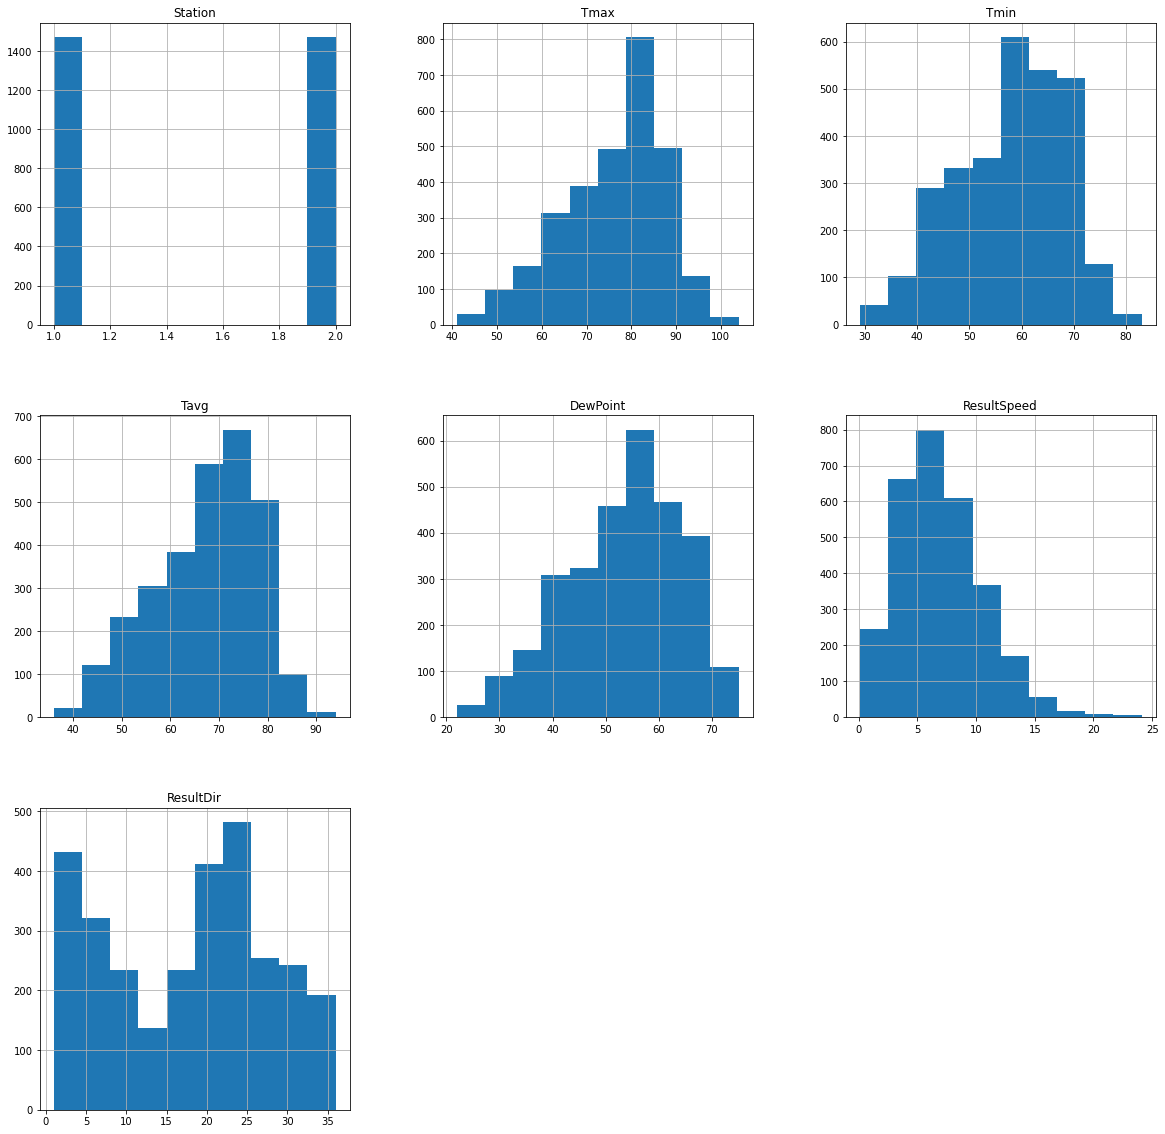

In [47]:
weather.hist(figsize=(20,20));

### Correlation Matrix for Weather

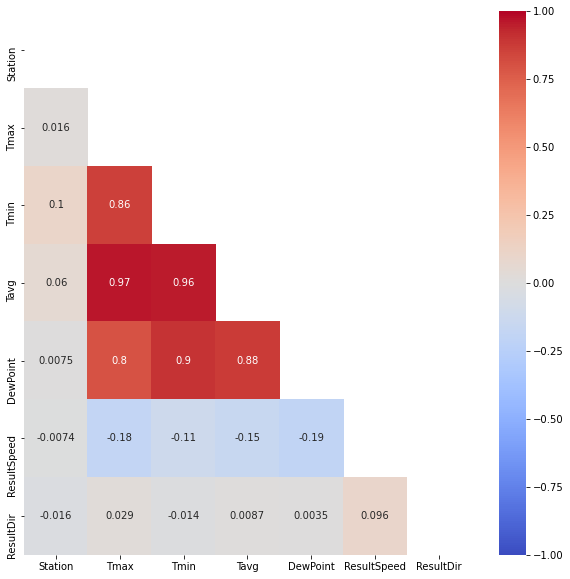

In [48]:
plt.figure(figsize=(10,10))
matrix = np.triu(weather.corr())

sns.heatmap(weather.corr(), annot=True, cmap='coolwarm', mask=matrix, vmin=-1, vmax=1);

## Spray data

# Feature Engineering

We can create a new feature to account for total sunlight time for each day.

In [33]:
weather['total_sunlight_mins'] = weather['Sunset'] - weather['Sunrise']

# Modelling

# Conclusion